In [44]:
import torch_geometric.transforms as T
import os.path as osp
from torch_geometric.datasets import Planetoid
from sklearn.manifold import TSNE
import torch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib.patches import Ellipse

In [2]:
# import cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

Processing...
Done!


In [3]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [46]:
# access data x
edges = data.edge_index
# turn this into a sparse matrix
obs_adj = torch.sparse_coo_tensor(edges, torch.ones(edges.shape[1]), (data.num_nodes, data.num_nodes))
obs_adj
# dense version
dense_adj = obs_adj.to_dense()

In [47]:
# turn to a dense matrix dense_adj
dense_adj = dense_adj.numpy()

In [6]:
labels = data.y.numpy()
len(labels)

2708

100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


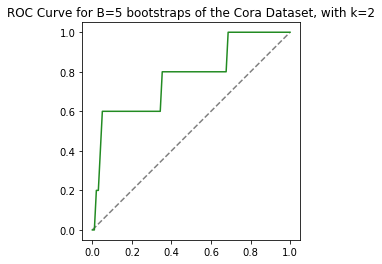

Area above the y=x line: 0.27954805683608863 for k=2
Area below the y=x line: 2.576525380320911e-06 for k=2
Total area (above and below y=x): 0.27955063336146896 for k=2


In [85]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

k = 2
B = 5
d = 7

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

# Provided code
p_hat_list = p_vals
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for B={B} bootstraps of the Cora Dataset, with k={k}")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Calculate the area between ROC and y=x line

def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below

x = np.linspace(0, 1, 100)
roc_interpolated = np.interp(x, alphas, roc)

# Compute areas
area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
total_area = area_above + area_below

print(f"Area above the y=x line: {area_above} for k={k}")
print(f"Area below the y=x line: {area_below} for k={k}")
print(f"Total area (above and below y=x): {total_area} for k={k}")

In [86]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [87]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = (labels.tolist())*(B+1)

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

In [88]:
import plotly.express as px

# Example plot
fig = px.scatter(yadf, 
                 x='Dimension_1', 
                 y='Dimension_2', 
                 color='tau', 
                 animation_frame='Matrix')

fig.show()

In [89]:
# tsne this embedding
tsne = TSNE(n_components=2, perplexity=30, random_state=0)

# df = yadf[(yadf["Matrix"] == 0) | (yadf['Matrix'] == 1)]
yhat_tsne = tsne.fit_transform(yhat)

In [90]:
yhat_tsne.shape

(16248, 2)

In [91]:
yhat_tsne_df = pd.DataFrame(yhat_tsne)
yhat_tsne_df.columns = ["Dimension_1", "Dimension_2"]

In [93]:
# add column for the matrix it is
yhat_tsne_df["Matrix"] = np.repeat(range(B+1), len(labels))
# repeats tau list the len of A_true_boots_list times
yhat_tsne_df["tau"] = (labels.tolist()*(B+1))

yhat_tsne_df0 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 0]
yhat_tsne_df1 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 1]

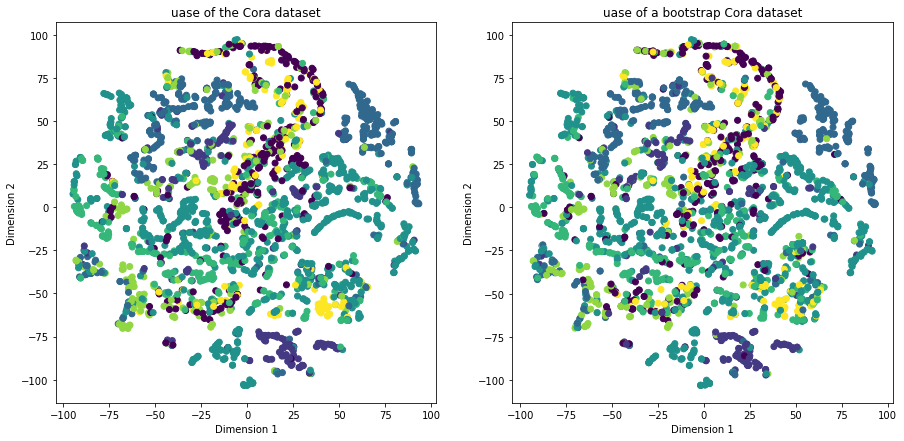

In [94]:
# plot two figures for the two different dfs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# plot the first df
scatter = ax1.scatter(yhat_tsne_df0["Dimension_1"], yhat_tsne_df0["Dimension_2"], c=yhat_tsne_df0["tau"], cmap='viridis')
ax1.set_title("uase of the Cora dataset")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# plot the second df
scatter = ax2.scatter(yhat_tsne_df1["Dimension_1"], yhat_tsne_df1["Dimension_2"], c=yhat_tsne_df1["tau"], cmap='viridis')
ax2.set_title("uase of a bootstrap Cora dataset")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")

# plt.colorbar(scatter)
plt.show()